<a href="https://colab.research.google.com/github/santoshgurujula/Springboard/blob/master/TimeSeriesModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# First, import the relevant modules
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
plt.rcParams['figure.figsize'] = 10,6

In [5]:
#pointing the path to google drive folder
%cd '/content/drive/My Drive/Springboard/data'
!ls

/content/drive/My Drive/Springboard/data
BOM500002.csv  BOM500013.csv  fig2.png
BOM500003.csv  BOM500014.csv  FinalStockData.csv
BOM500008.csv  BOM500020.csv  interpolating-timeseries-p1-pandas-fig1.png
BOM500009.csv  BOM500023.csv  nasdl.csv
BOM500010.csv  DJI.csv
BOM500012.csv  fig1.png


In [7]:
dataset = pd.read_csv('/content/drive/My Drive/Springboard/data/FinalStockData.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 739 entries, 0 to 738
Columns: 133 entries, Unnamed: 0 to Volume
dtypes: float64(131), int64(1), object(1)
memory usage: 768.0+ KB


In [8]:
dataset.head()

,Unnamed: 0,Date,Open_BOM500002,Open_BOM500003,Open_BOM500008,Open_BOM500009,Open_BOM500010,Open_BOM500012,Open_BOM500013,Open_BOM500014,Open_BOM500020,Open_BOM500023,High_BOM500002,High_BOM500003,High_BOM500008,High_BOM500009,High_BOM500010,High_BOM500012,High_BOM500013,High_BOM500014,High_BOM500020,High_BOM500023,Low_BOM500002,Low_BOM500003,Low_BOM500008,Low_BOM500009,Low_BOM500010,Low_BOM500012,Low_BOM500013,Low_BOM500014,Low_BOM500020,Low_BOM500023,Close_BOM500002,Close_BOM500003,Close_BOM500008,Close_BOM500009,Close_BOM500010,Close_BOM500012,Close_BOM500013,Close_BOM500014,...,% Deli. Qty to Traded Qty_BOM500003,% Deli. Qty to Traded Qty_BOM500008,% Deli. Qty to Traded Qty_BOM500009,% Deli. Qty to Traded Qty_BOM500010,% Deli. Qty to Traded Qty_BOM500012,% Deli. Qty to Traded Qty_BOM500013,% Deli. Qty to Traded Qty_BOM500014,% Deli. Qty to Traded Qty_BOM500020,% Deli. Qty to Traded Qty_BOM500023,Spread H-L_BOM500002,Spread H-L_BOM500003,Spread H-L_BOM500008,Spread H-L_BOM500009,Spread H-L_BOM500010,Spread H-L_BOM500012,Spread H-L_BOM500013,Spread H-L_BOM500014,Spread H-L_BOM500020,Spread H-L_BOM500023,Spread C-O_BOM500002,Spread C-O_BOM500003,Spread C-O_BOM500008,Spread C-O_BOM500009,Spread C-O_BOM500010,Spread C-O_BOM500012,Spread C-O_BOM500013,Spread C-O_BOM500014,Spread C-O_BOM500020,Spread C-O_BOM500023,Gross_Purchases,Gross_Sales,Net_Investment_INR,Net_Investment_USD,Conversion_Rate,Open,High,Low,Close,Adj Close,Volume
0,0,2017-01-02,1045.0,129.00,870.05,7.00,1275.00,21.9,15.50,2.50,49.05,NaN,1052.0,132.45,898.95,7.89,1275.0,22.00,16.08,2.50,49.90,NaN,1035.00,129.00,867.6,7.00,1214.15,21.50,14.86,2.30,48.35,NaN,1039.95,131.05,896.20,7.09,1219.25,21.60,15.30,2.37,...,59.65,12.15,87.01,21.24,77.39,38.58,82.68,27.28,NaN,17.00,3.45,31.35,0.89,60.85,0.50,1.22,0.20,1.55,NaN,-5.05,2.05,26.15,0.09,-55.75,-0.30,-0.20,-0.13,-0.25,NaN,2230.64,2796.67,-566.03,-83.29,67.9547,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2017-01-03,1069.9,132.30,900.00,7.04,1220.00,21.9,15.50,2.47,49.00,106.950000,1069.9,135.00,900.00,7.30,1222.0,21.90,15.70,2.48,49.80,106.950000,1037.90,132.00,882.9,7.04,1201.00,21.10,15.10,2.32,48.55,106.950000,1045.05,132.50,890.20,7.25,1215.25,21.70,15.32,2.43,...,37.15,24.99,89.13,54.61,89.96,64.98,80.71,44.10,100.000000,32.00,3.00,17.10,0.26,21.00,0.80,0.60,0.16,1.25,0.000000,-24.85,0.20,-9.80,0.21,-4.75,-0.20,-0.18,-0.04,-0.20,0.000000,867.26,1185.97,-318.71,-46.85,68.0225,19872.859375,19938.529297,19775.929688,19881.759766,19881.759766,339180000.0
2,2,2017-01-04,1050.0,134.15,892.00,7.13,1215.25,22.5,15.32,2.48,50.25,104.050000,1050.0,134.60,909.25,7.40,1225.0,22.75,15.44,2.50,51.90,104.050000,1033.50,131.25,890.0,7.11,1197.55,21.25,15.12,2.35,50.25,104.025000,1037.35,131.75,898.50,7.26,1212.50,22.75,15.28,2.47,...,61.49,24.11,83.89,92.28,74.31,84.28,96.69,31.95,100.000000,16.50,3.35,19.25,0.29,27.45,1.50,0.32,0.15,1.65,0.025000,-12.65,-2.40,6.50,0.13,-2.75,0.25,-0.04,-0.01,0.65,-0.025000,1863.97,2400.72,-536.75,-78.84,68.0864,19890.939453,19956.140625,19878.830078,19942.160156,19942.160156,280010000.0
3,3,2017-01-05,1051.9,132.00,905.00,7.02,1225.00,23.7,15.43,2.34,51.25,101.150000,1051.9,133.25,935.25,7.50,1225.0,23.85,15.52,2.49,54.40,101.150000,1029.55,130.00,900.0,7.02,1205.30,22.90,15.26,2.33,51.20,101.100000,1031.45,131.65,916.35,7.34,1216.55,23.85,15.48,2.41,...,59.06,27.79,72.79,23.37,73.78,76.37,69.64,32.58,100.000000,22.35,3.25,35.25,0.48,19.70,0.95,0.26,0.16,3.20,0.050000,-20.45,-0.35,11.35,0.32,-8.45,0.15,0.05,0.07,2.60,-0.050000,3534.18,4226.17,-691.99,-101.50,68.1791,19924.560547,19948.599609,19811.119141,19899.289063,19899.289063,269920000.0
4,4,2017-01-06,1037.0,132.90,916.35,7.35,1216.55,24.9,15.26,2.36,54.20,101.166667,1048.0,133.00,932.15,7.55,1232.4,25.00,15.45,2.45,54.35,101.766667,1035.55,129.55,915.0,7.21,1216.55,23.00,15.01,2.35,52.75,101.133333,1043.90,130.10,928.05,7.40,1222.15,24.95,15.11,2.45,...,49.28,12.28,85.11,82.03,70.79,73.11,87.23,38.97,83.333333,12.45,3.45,17.15,0.34,15.85,2.00,0.44,0.10,

In [10]:
print(dataset.columns)

Index(['Unnamed: 0', 'Date', 'Open_BOM500002', 'Open_BOM500003',
       'Open_BOM500008', 'Open_BOM500009', 'Open_BOM500010', 'Open_BOM500012',
       'Open_BOM500013', 'Open_BOM500014',
       ...
       'Gross_Sales', 'Net_Investment_INR', 'Net_Investment_USD',
       'Conversion_Rate', 'Open', 'High', 'Low', 'Close', 'Adj Close',
       'Volume'],
      dtype='object', length=133)


In [0]:
#select only 1 stock Open and close, Conversion_rate , Dowjones Open and close columns
features= ['Date','Open_BOM500002','Close_BOM500002', 'Conversion_Rate','Open','Close']
sub_dataset=dataset[features]

In [15]:
sub_dataset.head()

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,Open,Close
0,2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289063
4,2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


In [19]:
sub_dataset.sort_values(by='Date')

,Date,Open_BOM500002,Close_BOM500002,Conversion_Rate,Open,Close
0,2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
1,2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2,2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
3,2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289063
4,2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781
...,...,...,...,...,...,...
734,2019-12-24,1278.5,1255.15,71.1699,28572.570313,28515.449219
735,2019-12-26,1265.0,1268.50,71.1959,28539.460938,28621.390625
736,2019-12-27,1280.0,1275.75,71.2699,28675.339844,28645.259766
737,2019-12-30,1277.0,1287.35,71.2214,28654.759766,28462.140625


In [22]:
#parse string to datetime
sub_dataset['Date']=pd.to_datetime(sub_dataset['Date'],infer_datetime_format=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
IndexedDataset=sub_dataset.set_index(['Date'])

In [25]:
IndexedDataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 739 entries, 2017-01-02 to 2019-12-31
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Open_BOM500002   739 non-null    float64
 1   Close_BOM500002  739 non-null    float64
 2   Conversion_Rate  739 non-null    float64
 3   Open             738 non-null    float64
 4   Close            738 non-null    float64
dtypes: float64(5)
memory usage: 34.6 KB


In [24]:
IndexedDataset.head()

,Open_BOM500002,Close_BOM500002,Conversion_Rate,Open,Close
Date,,,,,
2017-01-02,1045.0,1039.95,67.9547,NaN,NaN
2017-01-03,1069.9,1045.05,68.0225,19872.859375,19881.759766
2017-01-04,1050.0,1037.35,68.0864,19890.939453,19942.160156
2017-01-05,1051.9,1031.45,68.1791,19924.560547,19899.289063
2017-01-06,1037.0,1043.90,67.7884,19906.960938,19963.800781


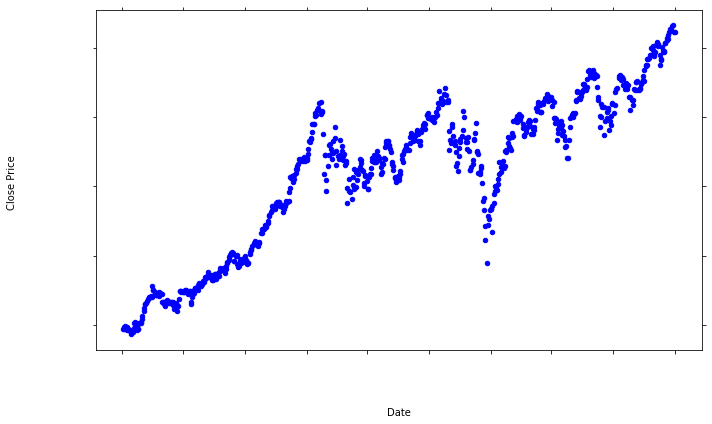

In [28]:
#plot Graph
#Plot stock Close price  against Date 
plt.scatter(IndexedDataset.index,
               IndexedDataset['Close'],
               color='blue',
               s=20)
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.grid(False)

plt.xlabel('Date', labelpad=40)
plt.ylabel('Close Price ', labelpad=40)

plt.tight_layout()
plt.savefig('fig1.png')
plt.show()
plt.close()

In [35]:
#Check Rolling mean and std
rolmean = IndexedDataset.rolling(window=5).mean()
rolstd =  IndexedDataset.rolling(window=5).std()

print(rolmean,rolstd)

            Open_BOM500002  Close_BOM500002  ...          Open         Close
Date                                         ...                            
2017-01-02             NaN              NaN  ...           NaN           NaN
2017-01-03             NaN              NaN  ...           NaN           NaN
2017-01-04             NaN              NaN  ...           NaN           NaN
2017-01-05             NaN              NaN  ...           NaN           NaN
2017-01-06         1050.76          1039.54  ...           NaN           NaN
...                    ...              ...  ...           ...           ...
2019-12-24         1359.62          1342.09  ...  28448.548047  28427.661719
2019-12-26         1317.90          1305.56  ...  28498.152344  28504.083985
2019-12-27         1283.50          1265.35  ...  28577.558203  28557.743750
2019-12-30         1273.10          1269.54  ...  28586.782032  28559.153906
2019-12-31         1281.10          1274.17  ...  28619.378125  28541.276172

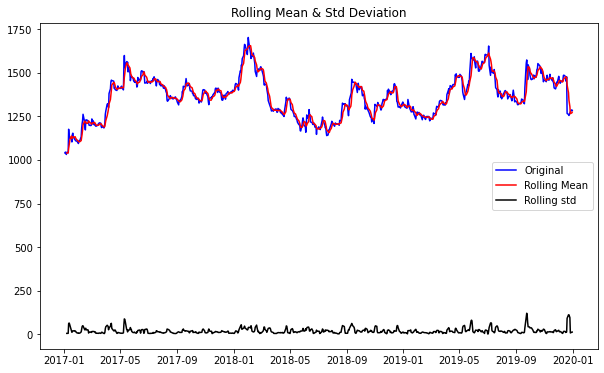

In [36]:
orig = plt.plot(IndexedDataset['Close_BOM500002'],color='blue',label='Original')
mean= plt.plot(rolmean['Close_BOM500002'],color='red',label='Rolling Mean')
std= plt.plot(rolstd['Close_BOM500002'],color='black',label='Rolling std')
plt.legend(loc='best')
plt.title('Rolling Mean & Std Deviation')
plt.show(block=False)

In [40]:
#Check Dickey - Fuller test
from statsmodels.tsa.stattools import adfuller

print('Results of Dickey Fuller test:')
dftest=adfuller(IndexedDataset['Close_BOM500002'],autolag='AIC')

dfoutput = pd.Series(dftest[0:4],index = ['Test Statistcs ', 'p-value', '#lags used', 'No of Observations used'] )
for key,value in dftest[4].items():
  dfoutput['Critical Value (%s)'%key]=value

print(dfoutput)

Results of Dickey Fuller test:
Test Statistcs              -3.577899
p-value                      0.006198
#lags used                   1.000000
No of Observations used    737.000000
Critical Value (1%)         -3.439254
Critical Value (5%)         -2.865470
Critical Value (10%)        -2.568863
dtype: float64


**p-value is less than 0.05, so we can reject null Hypothesis
and confirm the data is stationary**


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Partial Autocorrelation Function')

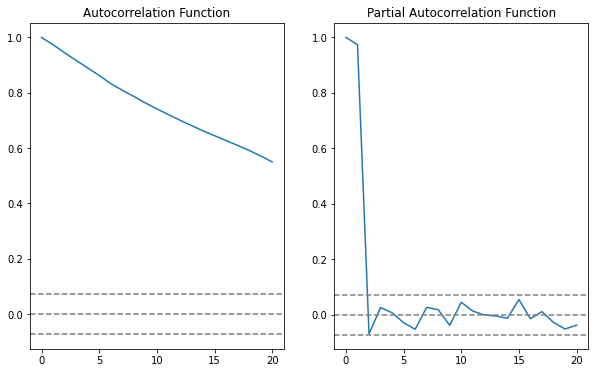

In [50]:
#plot ACF and PACF
from statsmodels.tsa.stattools import acf,pacf

lag_acf=acf(IndexedDataset['Close_BOM500002'],nlags=20)
lag_pacf = pacf (IndexedDataset['Close_BOM500002'],nlags=20, method ='ols')

#plot ACF
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(IndexedDataset['Close_BOM500002'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(IndexedDataset['Close_BOM500002'])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(IndexedDataset['Close_BOM500002'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(IndexedDataset['Close_BOM500002'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Plotting AR Model


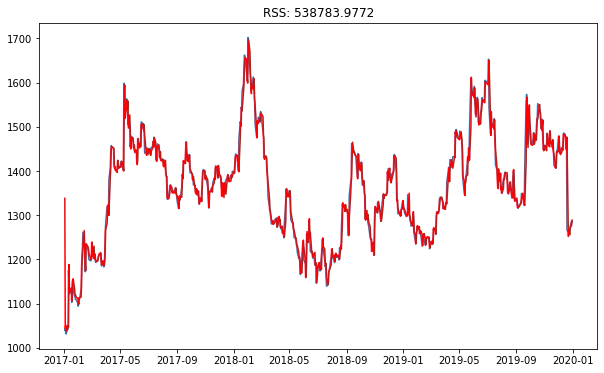

In [47]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(IndexedDataset['Close_BOM500002'],order=(2,0,2))
results_AR =model.fit(disp=-1)
plt.plot(IndexedDataset['Close_BOM500002'])
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-IndexedDataset['Close_BOM500002'])**2))
print('Plotting AR Model')